In [ ]:
!pip install pandas numpy==1.26.4 matplotlib statsmodels pandas_datareader datetime yfinance scikit-learn PyPortfolioOpt pandas-ta


In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2025-05-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date, auto_adjust=False).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

[*********************100%***********************]  503 of 503 completed


In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-30 A        56.704826   60.369999   60.480000   59.410000   59.540001   
           AAPL     35.794292   38.417500   38.607498   38.332500   38.355000   
           ABBV     46.889172   66.019997   66.199997   65.809998   65.889999   
           ABT      39.040840   45.000000   45.099998   44.209999   44.459999   
           ACGL     30.105448   31.660000   31.740000   31.490000   31.740000   
...                       ...         ...         ...         ...         ...   
2025-05-23 XYL     123.655098  124.050003  124.760002  123.570000  123.570000   
           YUM     144.740005  145.449997  145.899994  144.660004  145.220001   
           ZBH      92.400391   92.639999   94.000000   90.199997   90.820000   
           ZBRA    284.209991  284.209991  285.250000  278.510010  280.480011   
           ZTS     162.580002  162.580002  163.059998  160.139999  160.550003   

Price                  volume  
date       ticker              
2017-05-30 A        2576400.0  
           AAPL    80507600.0  
           ABBV     4803900.0  
           ABT      8119700.0  
           ACGL     1103100.0  
...                       ...  
2025-05-23 XYL      1282300.0  
           YUM      1062900.0  
           ZBH      3141100.0  
           ZBRA      325300.0  
           ZTS      2732200.0  

[990084 rows x 6 columns]

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}


In [ ]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df['garman_klass_vol'] = df['garman_klass_vol'].sub(df['garman_klass_vol'].mean()).div(df['garman_klass_vol'].std())

\begin{equation}
\text{RSI} = 100 - \frac{100}{1+RS}
\end{equation}
Where
\begin{equation}
\text{RS} = \frac{Avg. Gain}{Avg. Loss}
\end{equation}
Where the average is taken over some fixed period (here 20 days), used to detect overselling, overbuying (RSI > 70, overbuying, RSI < 30 overselling)

In [ ]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

Bollinger Bands:
\begin{equation}
BB_{low} = SMA - k * \sigma
\end{equation}
\begin{equation}
BB_{mid} = SMA
\end{equation}
\begin{equation}
BB_{high} = SMA + k * \sigma
\end{equation}
Choose k, (mostly 2) to be a unrealistic number to deviate from the mean<br>
Used to detect overselling, overbuying

In [ ]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_low'] = df['bb_low'].sub(df['bb_low'].mean()).div(df['bb_low'].std())

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_mid'] = df['bb_mid'].sub(df['bb_mid'].mean()).div(df['bb_mid'].std())

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])
df['bb_high'] = df['bb_high'].sub(df['bb_high'].mean()).div(df['bb_high'].std())

True Range is a meaure of volatility, how much does the price change

\begin{equation}
\text{TR}_t = \max\left(
\text{High}_t - \text{Low}_t,\
\left| \text{High}_t - \text{Close}_{t-1} \right|,\
\left| \text{Low}_t - \text{Close}_{t-1} \right|
\right)
\end{equation}


ATR is the moving average over some time periods of this TR

In [ ]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

Moving Average Convergence Divergence (MACD)<br>
MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price.

MACD Line = 12-period EMA − 26-period EMA
(EMA = Exponential Moving Average)

Signal Line = 9-period EMA of the MACD Line

MACD Histogram = MACD Line − Signal Line
(This shows momentum visually)

\begin{equation}
\text{EMA}_t = \text{Price}_t \cdot k + \text{EMA}_{t-1} \cdot (1 - k)
\end{equation}
k is smoothing factor like <br>
\begin{equation}
\text{k} = \frac{2}{n + 1}
\end{equation}
where n is the number of periods, here as k causes the recent price to have more importance than previous, intuition. the previous n points only contribute n - 1 points, the current point contributes 2 points

Some examples:
macd line is above signal line - bullish crossover<br>
macd line below signal line - Bearish Crossover<br>
Higtogram increasing - momentum rising<br>
histogram decreasing - momentum dropping<br>

In [ ]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

Dollar volume is a measure of the available stocks, we could multiply volume and price but that would be too big so we divide by 1e6 as millions of stocks are traded each day

In [ ]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

All indicators other than rsi should be normalized

In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2017-05-30 A        56.704826   60.369999   60.480000   59.410000   59.540001   
           AAPL     35.794292   38.417500   38.607498   38.332500   38.355000   
           ABBV     46.889172   66.019997   66.199997   65.809998   65.889999   
           ABT      39.040840   45.000000   45.099998   44.209999   44.459999   
           ACGL     30.105448   31.660000   31.740000   31.490000   31.740000   
...                       ...         ...         ...         ...         ...   
2025-05-23 XYL     123.655098  124.050003  124.760002  123.570000  123.570000   
           YUM     144.740005  145.449997  145.899994  144.660004  145.220001   
           ZBH      92.400391   92.639999   94.000000   90.199997   90.820000   
           ZBRA    284.209991  284.209991  285.250000  278.510010  280.480011   
           ZTS     162.580002  162.580002  163.059998  160.139999  160.550003   

Price                  volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-05-30 A        2576400.0          0.162617        NaN       NaN   
           AAPL    80507600.0          0.124987        NaN       NaN   
           ABBV     4803900.0         -1.399089        NaN       NaN   
           ABT      8119700.0         -0.035312        NaN       NaN   
           ACGL     1103100.0          0.152365        NaN       NaN   
...                       ...               ...        ...       ...   
2025-05-23 XYL      1282300.0          0.191268  54.600067  0.396367   
           YUM      1062900.0          0.190786  45.763745  0.616625   
           ZBH      3141100.0          0.215822  39.080390  0.108166   
           ZBRA      325300.0          0.197409  54.242185  1.133697   
           ZTS      2732200.0          0.193278  54.359281  0.670449   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2017-05-30 A            NaN       NaN       NaN       NaN     146.094315  
           AAPL         NaN       NaN       NaN       NaN    2881.712579  
           ABBV         NaN       NaN       NaN       NaN     225.250891  
           ABT          NaN       NaN       NaN       NaN     316.999910  
           ACGL         NaN       NaN       NaN       NaN      33.209319  
...                     ...       ...       ...       ...            ...  
2025-05-23 XYL     0.389623  0.381928  0.411810  1.244994     158.562932  
           YUM     0.575559  0.532894  0.886735 -0.541150     153.844152  
           ZBH     0.127373  0.146402 -0.025231 -0.997108     290.238867  
           ZBRA    1.240573  1.345223  0.257241  1.130596      92.453510  
           ZTS     0.658830  0.645601  0.712623  0.663686     444.201081  

[990084 rows x 14 columns]

Aggregate to monthly level and take top 150 most liquid stocks

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2017-07-31 A           91.825063   56.285103          0.127446  46.783993   
           AAPL      2915.393249   34.643616          0.108751  49.241174   
           ABBV       258.186402   50.098259         -1.413700  44.488245   
           ABT        247.002300   42.903427         -0.096690  55.535778   
           ACGL        42.369787   30.828129          0.175590  54.788624   
...                          ...         ...               ...        ...   
2025-05-31 XYL        162.066296  123.655098          0.191268  54.600067   
           YUM        263.836492  144.740005          0.190786  45.763745   
           ZBH        292.452494   92.400391          0.215822  39.080390   
           ZBRA       169.332128  284.209991          0.197409  54.242185   
           ZTS        519.558400  162.580002          0.193278  54.359281   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2017-07-31 A      -0.389338 -0.427828 -0.465561 -1.655805 -0.064914  
           AAPL   -0.925762 -0.950140 -0.972455 -1.326983 -0.173674  
           ABBV   -0.494528 -0.528115 -0.560681 -1.425588 -0.098908  
           ABT    -0.701044 -0.723849 -0.745109 -1.663495  0.198557  
           ACGL   -1.037484 -1.075796 -1.111839 -1.116143 -0.057947  
...                     ...       ...       ...       ...       ...  
2025-05-31 XYL     0.396367  0.389623  0.381928  0.411810  1.244994  
           YUM     0.616625  0.575559  0.532894  0.886735 -0.541150  
           ZBH     0.108166  0.127373  0.146402 -0.025231 -0.997108  
           ZBRA    1.133697  1.240573  1.345223  0.257241  1.130596  
           ZTS     0.670449  0.658830  0.645601  0.712623  0.663686  

[46818 rows x 9 columns]

Choose top 150 stocks


In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2018-06-30 AAPL     43.787857          0.146951  49.582426 -0.655710   
           ABBV     68.034233         -1.130107  38.080532 -0.193666   
           ABT      53.980732         -0.039067  47.018532 -0.425877   
           ACN     147.388321          0.033818  58.053467  0.592018   
           ADBE    243.809998          0.193548  50.937231  1.147732   
...                       ...               ...        ...       ...   
2025-05-31 VZ       43.320000          0.193144  50.257677 -0.669668   
           WDAY    238.009995          0.219781  42.799851  1.130209   
           WFC      72.830002          0.192994  52.525386 -0.150863   
           WMT      96.339996          0.192743  53.688231  0.177205   
           XOM     103.029999          0.192700  43.088785  0.249550   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2018-06-30 AAPL   -0.683497 -0.709863 -1.243780 -0.279704  
           ABBV   -0.192642 -0.191163 -0.609495 -1.009633  
           ABT    -0.460972 -0.495211 -1.296348 -0.352999  
           ACN     0.563458  0.533405 -0.932691  0.033655  
           ADBE    1.137780  1.125113 -1.114395 -0.109469  
...                     ...       ...       ...       ...  
2025-05-31 VZ     -0.710184 -0.749297 -0.044250  0.108399  
           WDAY    1.175819  1.218971  1.081855  1.266539  
           WFC    -0.158555 -0.165925  1.552743  1.272217  
           WMT     0.136447  0.095116  3.159608  1.012048  
           XOM     0.225634  0.201042  0.705899 -0.668218  

[12516 rows x 8 columns]

Calculate returns over some periods


In [ ]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2019-06-30 AAPL     47.530724          0.165740  56.282091 -0.656105   
           ABBV     55.922272         -0.534326  42.046291 -0.441420   
           ABT      75.733635          0.051605  64.665812 -0.152103   
           ACN     169.383636          0.096326  58.459482  0.747359   
           ADBE    294.649994          0.191685  58.679794  1.245139   
...                       ...               ...        ...       ...   
2025-05-31 VZ       43.320000          0.193144  50.257677 -0.669668   
           WDAY    238.009995          0.219781  42.799851  1.130209   
           WFC      72.830002          0.192994  52.525386 -0.150863   
           WMT      96.339996          0.192743  53.688231  0.177205   
           XOM     103.029999          0.192700  43.088785  0.249550   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2019-06-30 AAPL   -0.643919 -0.630154 -1.104790  0.023994   0.130519   
           ABBV   -0.399646 -0.356679 -0.221742 -0.936800  -0.052014   
           ABT    -0.152951 -0.153447 -0.944136  0.936888   0.104689   
           ACN     0.718263  0.687310 -1.063650  0.163971   0.037626   
           ADBE    1.270600  1.293256 -0.882265  0.431021   0.087671   
...                     ...       ...       ...       ...        ...   
2025-05-31 VZ     -0.710184 -0.749297 -0.044250  0.108399  -0.016795   
           WDAY    1.175819  1.218971  1.081855  1.266539  -0.028531   
           WFC    -0.158555 -0.165925  1.552743  1.272217   0.031257   
           WMT     0.136447  0.095116  3.159608  1.012048  -0.006962   
           XOM     0.225634  0.201042  0.705899 -0.668218  -0.015631   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2019-06-30 AAPL    -0.004965   0.015095   0.039950  -0.013235    0.006858  
           ABBV    -0.042929  -0.029421  -0.032749  -0.024888   -0.016205  
           ABT      0.028136   0.018439   0.026936   0.016743    0.028618  
           ACN      0.005732   0.019101   0.047516   0.011115    0.011659  
           ADBE     0.009291   0.034051   0.045016   0.009775    0.015908  
...                      ...        ...        ...        ...         ...  
2025-05-31 VZ      -0.014929   0.007033   0.001706   0.009510    0.009765  
           WDAY     0.009546  -0.033149  -0.008151  -0.011112    0.009909  
           WFC      0.009976  -0.022152  -0.005724   0.026541    0.018406  
           WMT      0.048830  -0.006026   0.008040   0.025710    0.033214  
           XOM     -0.064967  -0.022513  -0.019352  -0.012027   -0.007894  

[10325 rows x 14 columns]

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100) #div 100 cuz it was in percentages, last so we get last day of month so we can join later

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-06-30 AAPL    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.130519
           ABBV    0.0692  0.0037 -0.0067  0.0091 -0.0040  -0.052014
           ABT     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.104689
           ACN     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.037626
           ADBE    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.087671
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10185 rows x 6 columns]

first we wfilter out stocks with not enough data

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2019-06-30 AAPL    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.130519
           ABBV    0.0692  0.0037 -0.0067  0.0091 -0.0040  -0.052014
           ABT     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.104689
           ACN     0.0692  0.0037 -0.0067  0.0091 -0.0040   0.037626
           ADBE    0.0692  0.0037 -0.0067  0.0091 -0.0040   0.087671
...                   ...     ...     ...     ...     ...        ...
2025-04-30 VZ     -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.013058
           WDAY   -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.049116
           WFC    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.010865
           WMT    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267   0.107757
           XOM    -0.0085 -0.0185 -0.0341 -0.0284 -0.0267  -0.111830

[10104 rows x 6 columns]

calculate roolling factor betas

a factor beta is how sensitive an asset is to a particular risk factor(like market return size value etc)

The coefficients in the regression are the bets, so we use ols for it, coeff with market is market exposure, with value is value exposure etc

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.904801 -1.064599  0.905388  0.657991 -0.070619
           WDAY    1.108715 -0.937077  0.037348 -1.896113 -0.421493
           WFC     0.877760 -0.095226  0.559152 -1.655161 -0.085206
           WMT     0.787344  0.091226 -0.722477  0.394635  0.633478
           XOM     0.476823 -0.287362  1.039672  1.215639  0.114549

[10104 rows x 5 columns]

the betas are of the previous 24 months so it can only be used from next month onwards, so we shift it

In [ ]:
betas.groupby('ticker', group_keys = False).shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2019-06-30 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-04-30 VZ      0.959161 -1.093274  1.057762  0.790967 -0.260801
           WDAY    1.030206 -1.009928  0.260714 -2.140773 -0.909356
           WFC     0.790558 -0.006038  0.147109 -1.848591  0.508105
           WMT     0.969314  0.042702 -0.396603  0.861628  0.313591
           XOM     0.432076 -0.233825  0.798082  1.119960  0.470853

[10104 rows x 5 columns]

In [ ]:
data = data.join(betas.groupby('ticker', group_keys = False).shift())

factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis = 1)

data = data.dropna()

k means clustering to find the assets of each month most similar to each other

we want to cluster around the rsi values as we use a rsi centered strategy

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [ ]:
from sklearn.cluster import KMeans

if 'cluster' in data.columns:
  data = data.drop('cluster', axis = 1)
def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=1, init = initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-06-30 AAPL            0.165740  56.282091 -0.656105 -0.643919 -0.630154   
           ABBV           -0.534326  42.046291 -0.441420 -0.399646 -0.356679   
           ABT             0.051605  64.665812 -0.152103 -0.152951 -0.153447   
           ACN             0.096326  58.459482  0.747359  0.718263  0.687310   
           ADBE            0.191685  58.679794  1.245139  1.270600  1.293256   
...                             ...        ...       ...       ...       ...   
2025-05-31 VZ              0.193144  50.257677 -0.669668 -0.710184 -0.749297   
           WDAY            0.219781  42.799851  1.130209  1.175819  1.218971   
           WFC             0.192994  52.525386 -0.150863 -0.158555 -0.165925   
           WMT             0.192743  53.688231  0.177205  0.136447  0.095116   
           XOM             0.192700  43.088785  0.249550  0.225634  0.201042   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -1.104790  0.023994   0.130519  -0.004965   0.015095   
           ABBV   -0.221742 -0.936800  -0.052014  -0.042929  -0.029421   
           ABT    -0.944136  0.936888   0.104689   0.028136   0.018439   
           ACN    -1.063650  0.163971   0.037626   0.005732   0.019101   
           ADBE   -0.882265  0.431021   0.087671   0.009291   0.034051   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ     -0.044250  0.108399  -0.016795  -0.014929   0.007033   
           WDAY    1.081855  1.266539  -0.028531   0.009546  -0.033149   
           WFC     1.552743  1.272217   0.031257   0.009976  -0.022152   
           WMT     3.159608  1.012048  -0.006962   0.048830  -0.006026   
           XOM     0.705899 -0.668218  -0.015631  -0.064967  -0.022513   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.039950  -0.013235    0.006858  1.229640 -0.077216   
           ABBV    -0.032749  -0.024888   -0.016205  0.544290  0.121623   
           ABT      0.026936   0.016743    0.028618  0.786788 -0.064376   
           ACN      0.047516   0.011115    0.011659  1.155037 -0.185419   
           ADBE     0.045016   0.009775    0.015908  1.390836 -0.647521   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ       0.001706   0.009510    0.009765  0.529418 -0.550327   
           WDAY    -0.008151  -0.011112    0.009909  1.159876 -0.659771   
           WFC     -0.005724   0.026541    0.018406  1.071348 -0.131470   
           WMT      0.008040   0.025710    0.033214  0.673055 -0.287001   
           XOM     -0.019352  -0.012027   -0.007894  0.936466 -0.073327   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-06-30 AAPL   -0.690846  0.384652  0.404050        2  
           ABBV   -0.054228  0.267435  0.596129        0  
           ABT    -0.346241  0.063837  1.002291        3  
           ACN    -0.239592  0.196433 -0.049084        2  
           ADBE   -0.215788  0.266277 -0.442814        2  
...                     ...       ...       ...      ...  
2025-05-31 VZ      0.411722  0.161332 -0.001613        1  
           WDAY   -0.294388 -1.000670 -0.482132        1  
           WFC     1.585938 -0.786083 -1.088352        2  
           WMT    -0.326905  0.256969  0.520100        2  
           XOM     0.932801 -0.339565  0.357285        1  

[10104 rows x 19 columns]

In [ ]:
data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-06-30 AAPL            0.165740  56.282091 -0.656105 -0.643919 -0.630154   
           ABBV           -0.534326  42.046291 -0.441420 -0.399646 -0.356679   
           ABT             0.051605  64.665812 -0.152103 -0.152951 -0.153447   
           ACN             0.096326  58.459482  0.747359  0.718263  0.687310   
           ADBE            0.191685  58.679794  1.245139  1.270600  1.293256   
...                             ...        ...       ...       ...       ...   
2025-05-31 VZ              0.193144  50.257677 -0.669668 -0.710184 -0.749297   
           WDAY            0.219781  42.799851  1.130209  1.175819  1.218971   
           WFC             0.192994  52.525386 -0.150863 -0.158555 -0.165925   
           WMT             0.192743  53.688231  0.177205  0.136447  0.095116   
           XOM             0.192700  43.088785  0.249550  0.225634  0.201042   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 AAPL   -1.104790  0.023994   0.130519  -0.004965   0.015095   
           ABBV   -0.221742 -0.936800  -0.052014  -0.042929  -0.029421   
           ABT    -0.944136  0.936888   0.104689   0.028136   0.018439   
           ACN    -1.063650  0.163971   0.037626   0.005732   0.019101   
           ADBE   -0.882265  0.431021   0.087671   0.009291   0.034051   
...                     ...       ...        ...        ...        ...   
2025-05-31 VZ     -0.044250  0.108399  -0.016795  -0.014929   0.007033   
           WDAY    1.081855  1.266539  -0.028531   0.009546  -0.033149   
           WFC     1.552743  1.272217   0.031257   0.009976  -0.022152   
           WMT     3.159608  1.012048  -0.006962   0.048830  -0.006026   
           XOM     0.705899 -0.668218  -0.015631  -0.064967  -0.022513   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 AAPL     0.039950  -0.013235    0.006858  1.229640 -0.077216   
           ABBV    -0.032749  -0.024888   -0.016205  0.544290  0.121623   
           ABT      0.026936   0.016743    0.028618  0.786788 -0.064376   
           ACN      0.047516   0.011115    0.011659  1.155037 -0.185419   
           ADBE     0.045016   0.009775    0.015908  1.390836 -0.647521   
...                      ...        ...         ...       ...       ...   
2025-05-31 VZ       0.001706   0.009510    0.009765  0.529418 -0.550327   
           WDAY    -0.008151  -0.011112    0.009909  1.159876 -0.659771   
           WFC     -0.005724   0.026541    0.018406  1.071348 -0.131470   
           WMT      0.008040   0.025710    0.033214  0.673055 -0.287001   
           XOM     -0.019352  -0.012027   -0.007894  0.936466 -0.073327   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-06-30 AAPL   -0.690846  0.384652  0.404050        2  
           ABBV   -0.054228  0.267435  0.596129        0  
           ABT    -0.346241  0.063837  1.002291        3  
           ACN    -0.239592  0.196433 -0.049084        2  
           ADBE   -0.215788  0.266277 -0.442814        2  
...                     ...       ...       ...      ...  
2025-05-31 VZ      0.411722  0.161332 -0.001613        1  
           WDAY   -0.294388 -1.000670 -0.482132        1  
           WFC     1.585938 -0.786083 -1.088352        2  
           WMT    -0.326905  0.256969  0.520100        2  
           XOM     0.932801 -0.339565  0.357285        1  

[10104 rows x 19 columns]

we did not normalize rsi so that it would have a disproprotionate effect(rsi is 0 to 100, everything else is -1 to 1) on the kmeans and show a good visualization, normally we should normalize rsi as well

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,1] , cluster_0.iloc[:,5] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,1] , cluster_1.iloc[:,5] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,1] , cluster_2.iloc[:,5] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,1] , cluster_3.iloc[:,5] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

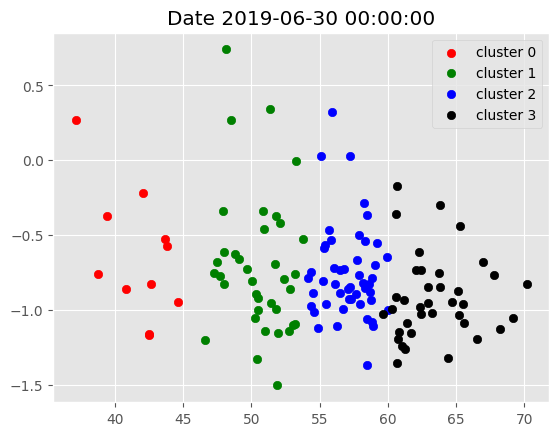

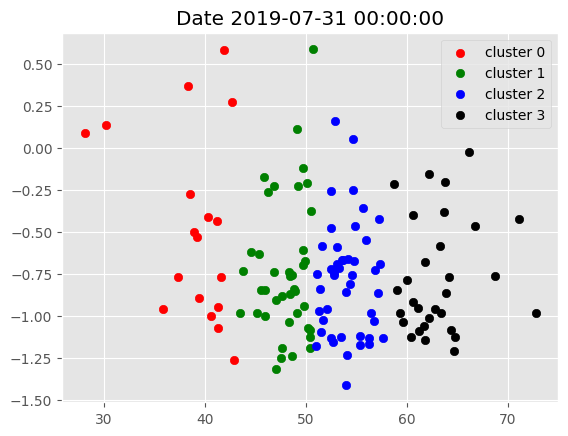

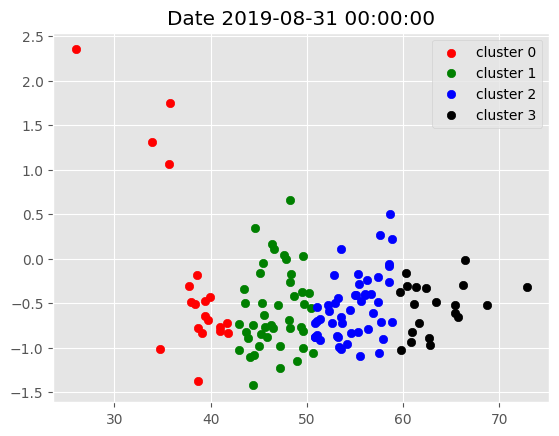

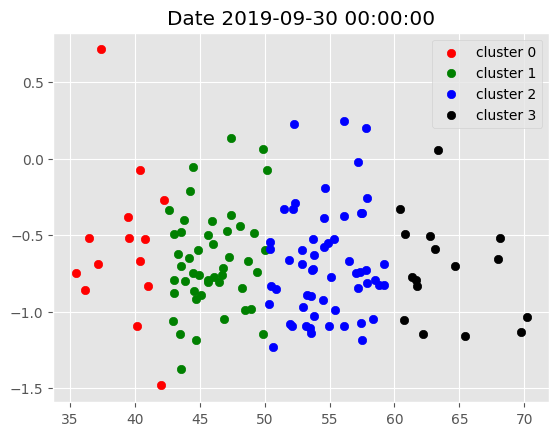

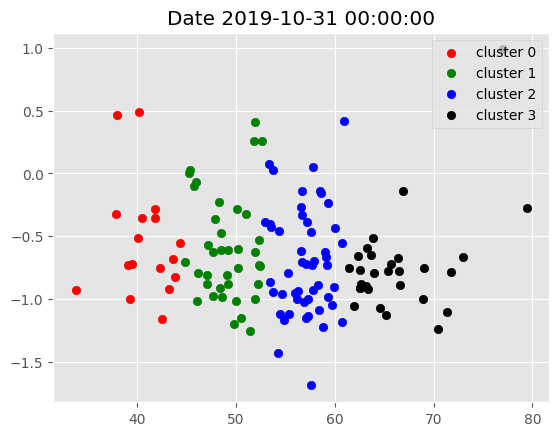

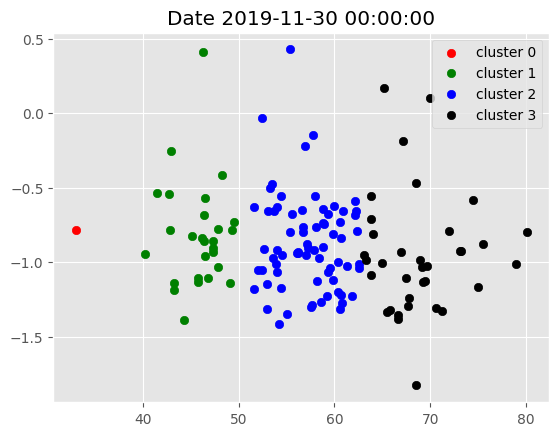

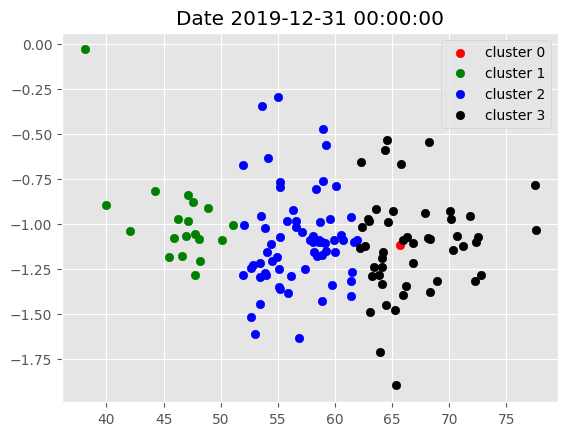

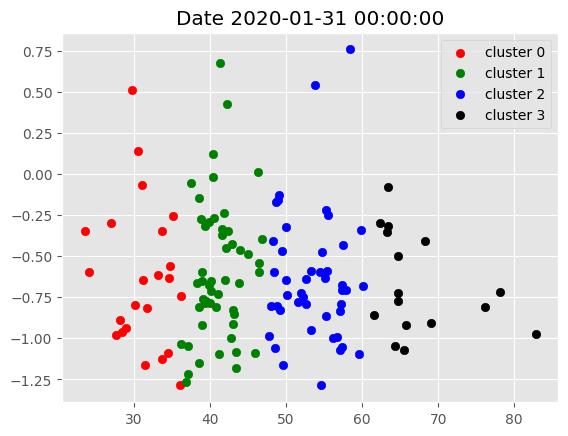

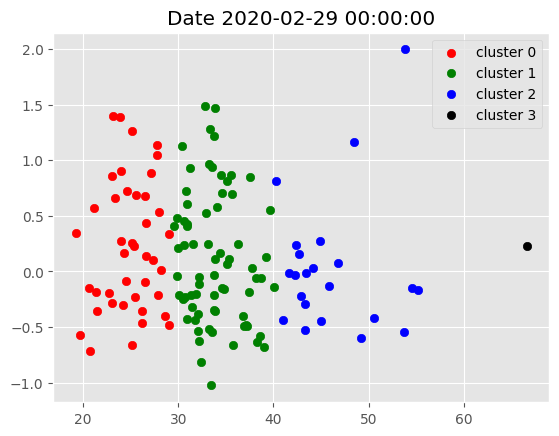

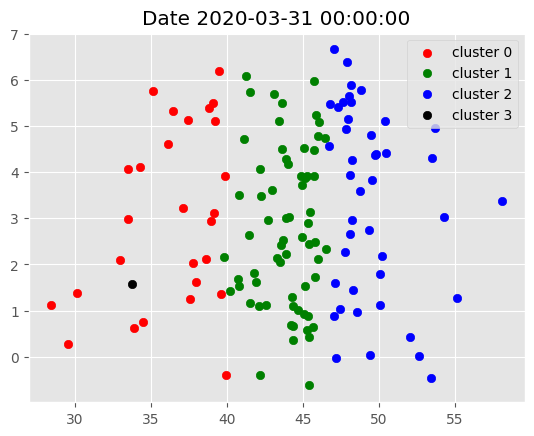

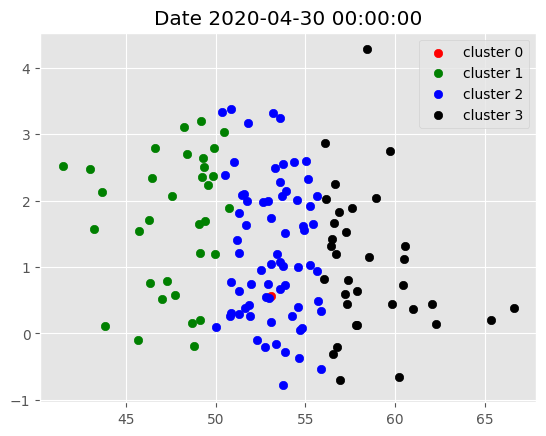

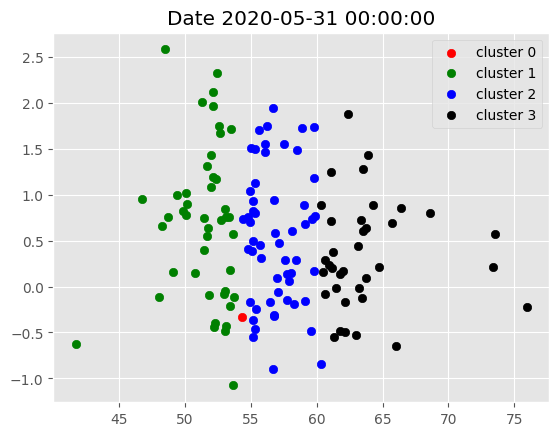

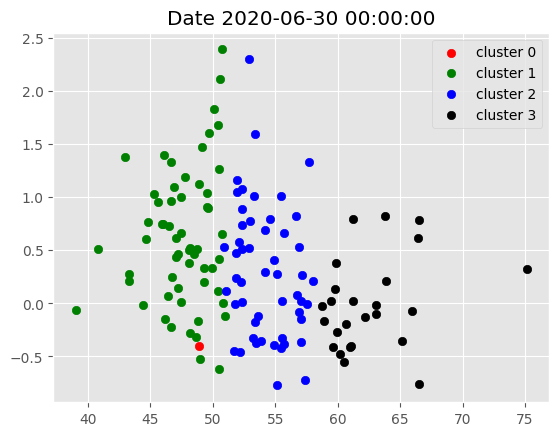

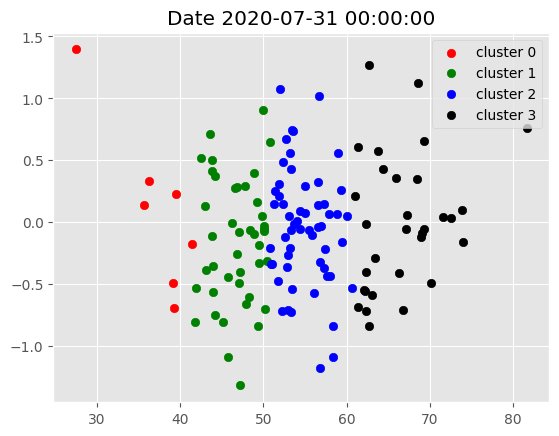

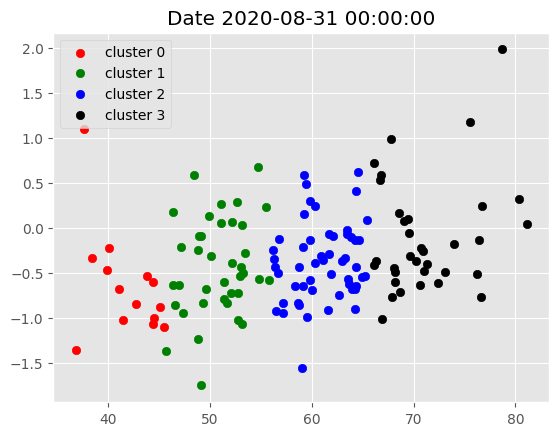

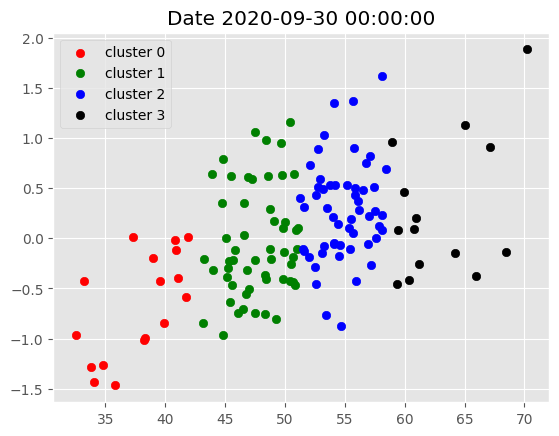

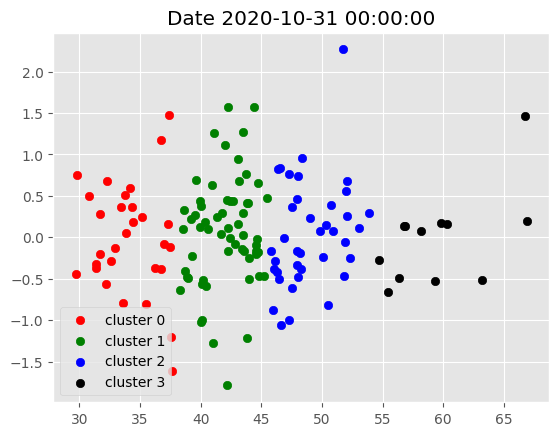

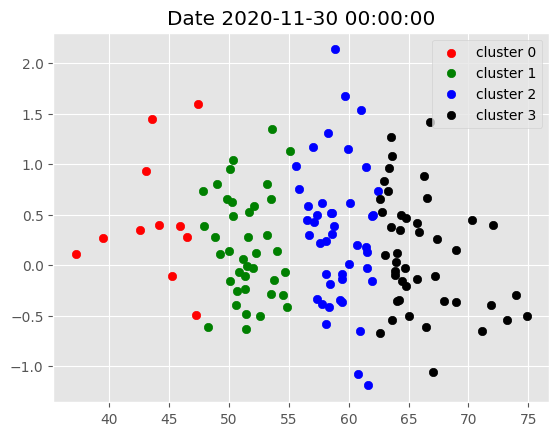

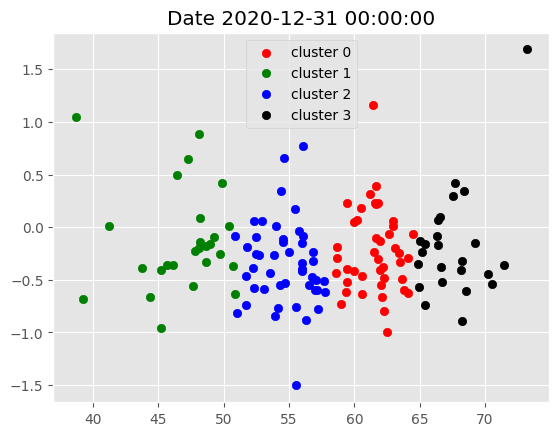

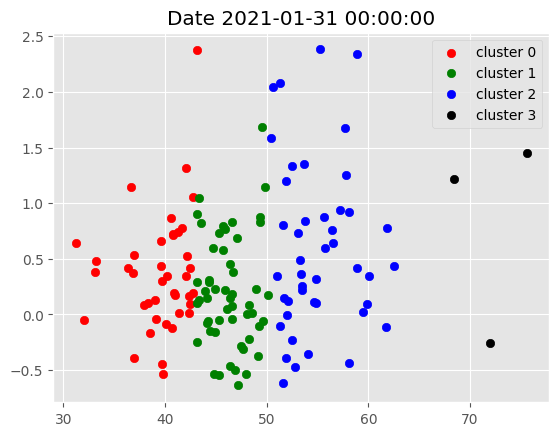

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist()[:20]:

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

Our strategy:

Stocks that have good momentum (high rsi) will continue up, so we buy the stocks of the last cluster as it corresponds to higher rsi

then we build a portfolio based on Efficient Frontier max sharpe ratio optimization

efficient frontier is the set of portfolios that give maximal return for their defined risk, it fors kind of like a upward smile


sharpe ratio is
\begin{equation}
SR = \frac{return - riskfree}{volatility}
\end{equation}

In [ ]:
#first lets choose the cluster 3 assets
filtered_df = data[data['cluster'] == 3]
filtered_df

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2019-06-30 ABT             0.051605  64.665812 -0.152103 -0.152951 -0.153447   
           AMAT            0.136573  60.826320 -0.810400 -0.805556 -0.798803   
           AMGN           -0.265150  60.742342  0.600716  0.592238  0.582326   
           BDX             0.097819  65.264136  0.986722  0.979798  0.970545   
           BKNG            0.194947  59.641550  3.226507  3.239646  3.245310   
...                             ...        ...       ...       ...       ...   
2025-05-31 NOW             0.196212  59.542706  2.600056  2.615476  2.624892   
           NVDA            0.201172  60.529372  0.267575  0.381513  0.495274   
           PM              0.194192  67.080466  0.745425  0.730221  0.713218   
           SCHW            0.194063  64.495314 -0.012425 -0.004774  0.002936   
           TSLA            0.204850  61.075135  1.236741  1.372913  1.506735   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2019-06-30 ABT    -0.944136  0.936888   0.104689   0.028136   0.018439   
           AMAT   -1.145290  0.115416   0.160765   0.012064   0.044084   
           AMGN   -1.194500  0.542890   0.105459   0.018090  -0.007270   
           BDX    -0.441557  1.188375   0.083033   0.024789   0.004112   
           BKNG   -1.024749  0.284498   0.131921   0.005301   0.024205   
...                     ...       ...        ...        ...        ...   
2025-05-31 NOW     1.399303  2.897049   0.051685   0.123187   0.026064   
           NVDA    1.854389  3.519648   0.205380   0.100630   0.016748   
           PM      2.390061  2.175131   0.039858   0.059527   0.050013   
           SCHW    0.294075  1.738768   0.077157   0.058343   0.033057   
           TSLA    1.254216  2.086488   0.202651   0.144283   0.050185   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2019-06-30 ABT      0.026936   0.016743    0.028618  0.786788 -0.064376   
           AMAT     0.055883   0.018607   -0.000642  1.422322  0.595321   
           AMGN    -0.006408  -0.010437    0.002364  0.713671 -0.145862   
           BDX      0.019907  -0.002833    0.005272  0.553530 -0.155240   
           BKNG     0.014221  -0.006276   -0.006491  1.386873 -0.031723   
...                      ...        ...         ...       ...       ...   
2025-05-31 NOW     -0.007289   0.018051    0.036011  0.937121 -0.331192   
           NVDA    -0.008546   0.010659    0.015164  1.699910 -0.213863   
           PM       0.053355   0.045366    0.051963  0.655582 -0.044826   
           SCHW     0.010231   0.034414    0.015971  0.892215 -0.136852   
           TSLA    -0.002830   0.052500    0.055201  2.054525  0.204513   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2019-06-30 ABT    -0.346241  0.063837  1.002291        3  
           AMAT    0.196474  0.351854 -0.518735        3  
           AMGN    0.189310  0.618982  0.777303        3  
           BDX    -0.289631 -0.226118  1.182441        3  
           BKNG    0.464538 -0.163259 -0.145340        3  
...                     ...       ...       ...      ...  
2025-05-31 NOW    -0.382519 -0.868421 -0.378244        3  
           NVDA   -0.853013  0.427520 -0.888270        3  
           PM      0.291544  0.264676  0.558004        3  
           SCHW    1.580184 -1.085286 -1.118302        3  
           TSLA   -0.710525 -1.131591 -1.247605        3  

[1866 rows x 19 columns]

Now lets make a dictionary of key month and value of list of assets we buy

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2019-07-01': ['ABT',
  'AMAT',
  'AMGN',
  'BDX',
  'BKNG',
  'BLK',
  'BRK-B',
  'C',
  'CAT',
  'CHTR',
  'COST',
  'DE',
  'DHR',
  'EA',
  'EBAY',
  'EL',
  'EXPE',
  'GM',
  'GS',
  'HD',
  'HON',
  'LMT',
  'MAR',
  'MCD',
  'MDT',
  'MGM',
  'MPC',
  'NOC',
  'ORCL',
  'SBUX',
  'T',
  'TGT',
  'TMO',
  'V',
  'VLO',
  'WDC',
  'WMT'],
 '2019-08-01': ['AAPL',
  'ABT',
  'AMAT',
  'AMGN',
  'BAC',
  'CMG',
  'COST',
  'EBAY',
  'GM',
  'GOOG',
  'GOOGL',
  'GS',
  'HUM',
  'IBM',
  'JPM',
  'LRCX',
  'MDT',
  'MGM',
  'MU',
  'NOC',
  'PANW',
  'PG',
  'SBUX',
  'SHW',
  'T',
  'TXN',
  'UNP',
  'UPS',
  'USB',
  'WDC'],
 '2019-09-01': ['AMGN',
  'AMT',
  'CHTR',
  'CMG',
  'COST',
  'CVS',
  'HD',
  'INTU',
  'KO',
  'LMT',
  'LOW',
  'MDT',
  'NEE',
  'NOC',
  'PEP',
  'SHW',
  'T',
  'TGT',
  'UPS',
  'WMT'],
 '2019-10-01': ['AAPL',
  'ABBV',
  'BMY',
  'DE',
  'HD',
  'IBM',
  'MPC',
  'NEE',
  'NKE',
  'PG',
  'SHW',
  'T',
  'TGT',
  'VZ',
  'WFC',
  'WMT'],
 '2019-11-01'

Define portfolio optimization function<br>
We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
<br>
To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.
<br>
Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
#252 days is 1 year of trading data
def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1), #at max a stock could be 10% of my portfolio
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

download price series for the shortlisted stocks

In [ ]:
data.groupby('date', group_keys = False).size()

In [ ]:
stocks = filtered_df.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=filtered_df.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=filtered_df.index.get_level_values('date').unique()[-1], auto_adjust = False)

new_df

[*********************100%***********************]  154 of 154 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABBV        ABNB         ABT         ACN   
Date                                                                     
2018-07-02   44.277504   68.372047         NaN   53.989582  147.063950   
2018-07-03   43.506351   68.739159         NaN   53.821419  147.163040   
2018-07-05   43.856449   69.378021         NaN   54.281651  148.478455   
2018-07-06   44.464375   71.169762         NaN   55.016266  148.217163   
2018-07-09   45.081787   71.257889         NaN   55.264091  149.676773   
...                ...         ...         ...         ...         ...   
2025-05-23  195.270004  183.259995  126.720001  131.300003  309.579987   
2025-05-27  200.210007  185.720001  129.399994  132.940002  315.429993   
2025-05-28  200.419998  183.089996  128.669998  132.020004  315.989990   
2025-05-29  199.949997  185.619995  128.360001  132.850006  317.730011   
2025-05-30  200.850006  186.110001  129.000000  133.580002  316.820007   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        ALGN  ...   
Date                                                                    ...   
2018-07-02  243.259995   84.500183  116.432182  131.899994  340.279999  ...   
2018-07-03  242.009995   82.920906  115.396164  131.600006  338.679993  ...   
2018-07-05  244.179993   84.579163  115.439339  132.800003  341.380005  ...   
2018-07-06  248.190002   85.281052  115.879631  135.110001  347.470001  ...   
2018-07-09  249.770004   85.263519  116.138626  134.970001  348.970001  ...   
...                ...         ...         ...         ...         ...  ...   
2025-05-23  407.690002  209.516083  319.493622  295.350006  170.800003  ...   
2025-05-27  413.100006  215.906982  324.090637  300.359985  178.550003  ...   
2025-05-28  412.230011  214.642731  322.528473  299.230011  180.110001  ...   
2025-05-29  413.359985  214.772156  322.508545  297.000000  183.050003  ...   
2025-05-30  415.089996  213.010162  323.911560  296.119995  180.940002  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ       WBA     WDAY      WDC       WFC   
Date                                                                           
2018-07-02  3748500  2283600  13141200  11309700  1297000  3289640  21204900   
2018-07-03  2078100  1059900   8441100   5602300   935700  2466469  12830400   
2018-07-05  3400600  1178600  11279600  12473000  2573600  3423395  16788600   
2018-07-06  2461300  1518900  10203800   9741000  1929200  2959683  12389100   
2018-07-09  2726500  1334700  10491200   7513000  2956200  3588241  16684000   
...             ...      ...       ...       ...      ...      ...       ...   
2025-05-23  2053000  1427300  12393400   9769700  9915000  5763200   9260900   
2025-05-27  2426400  2048300  12873700  10568700  4740700  6374500  11014100   
2025-05-28  3125200  1209500  12783000   8662100  2721700  6782100   8711100   
2025-05-29  2567600   882500   9960400   8877200  2991400  4570900  14016600   
2025-05-30  3870500  2581700  26569500  69213700  3491600  7402800  17042000   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2018-07-02  24375300  6755000   9998300  
2018-07-03  13188600  2227700   7197300  
2018-07-05  16102500  2626100   9035700  
2018-07-06  16841100  2048800   7637100  
2018-07-09  19726200  4568900   7158600  
...              ...      ...       ...  
2025-05-23  13668600  1335800  12061600  
2025-05-27  17180900  1813400  13043600  
2025-05-28  11220100  1405600  14292400  
2025-05-29  14338000  2208400  13825300  
2025-05-30  29980100  6827900  28645800  

[1738 rows x 924 columns]

notie the first line, the .diff is basically  log(pt/pt-1) so its log of percentage return, the good thing about this is we can then add all returns and get actual return, this way we dont need to set and portfolio value as the previous return would simply get multiplied into the current one, thus fulfilling the exponential nature we expect

In [ ]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2019-07-01,0.005176
2019-07-02,0.004355
2019-07-03,0.008828
2019-07-05,-0.003391
2019-07-08,-0.002990
...,...
2025-05-23,0.003653
2025-05-27,0.007111
2025-05-28,-0.002749


<Axes: xlabel='date'>

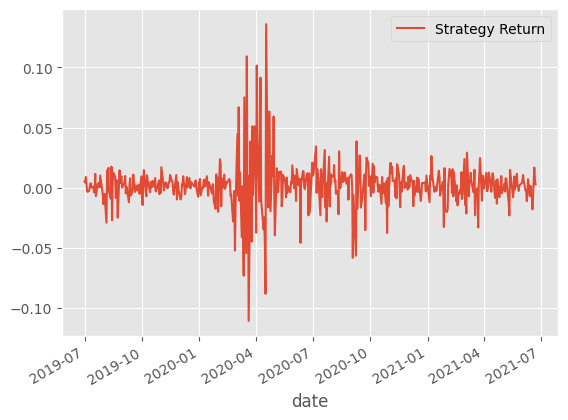

In [ ]:
portfolio_df[:500].plot()

In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today(), auto_adjust = False)

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1).stack().xs('SPY', level = 1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2019-07-01,0.005176,0.009037
2019-07-02,0.004355,0.002601
2019-07-03,0.008828,0.007963
2019-07-05,-0.003391,-0.001138
2019-07-08,-0.002990,-0.005510
...,...,...
2025-05-23,0.003653,-0.006849
2025-05-27,0.007111,0.020577
2025-05-28,-0.002749,-0.005802
2025-05-29,-0.006147,0.003940


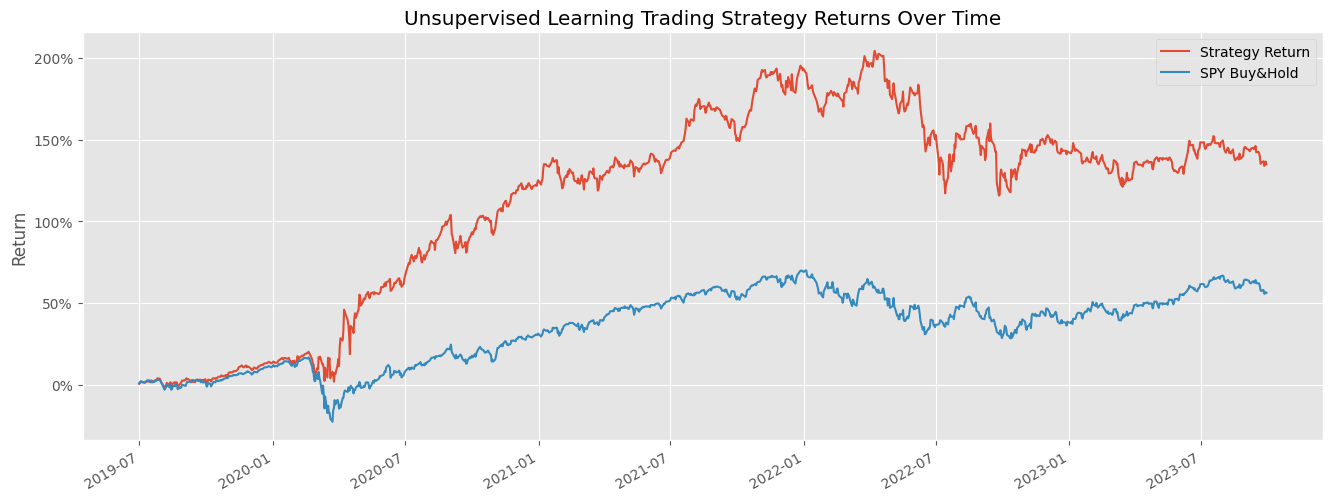

In [ ]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(portfolio_df.cumsum()) - 1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()